# Analysis of FX Rates and the VIX

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import yfinance as yf
import linearmodels as plm
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

## Data Cleaning

In [2]:
# Import fx dataset
fx = pd.read_csv('fx.csv')
fx

,currency,quarter,fx_usd
0,AUD,1991q2,1.303271
1,AUD,1991q3,1.253918
2,AUD,1991q4,1.311992
3,AUD,1992q1,1.297859
4,AUD,1992q2,1.338330
...,...,...,...
2090,ZAR,2019q3,15.136300
2091,ZAR,2019q4,14.000000
2092,ZAR,2020q1,17.837900
2093,ZAR,2020q2,17.351200


In [3]:
# Import VIX dataset
data = pd.read_excel('VIXCLS.xls')
vix = data.iloc[10:].reset_index()
vix

,index,FRED Graph Observations,Unnamed: 1
0,10,1990-01-02 00:00:00,17.24
1,11,1990-01-03 00:00:00,18.19
2,12,1990-01-04 00:00:00,19.22
3,13,1990-01-05 00:00:00,20.11
4,14,1990-01-08 00:00:00,20.26
...,...,...,...
8144,8154,2021-03-22 00:00:00,18.88
8145,8155,2021-03-23 00:00:00,20.3
8146,8156,2021-03-24 00:00:00,21.2
8147,8157,2021-03-25 00:00:00,19.81


In [4]:
### Clean fx dataset

# Clean quarter column and make it a date (end of the quarter)
def quarter_to_date(quarter):
    year, qtr = quarter.split('q')
    year = int(year)
    qtr = int(qtr)
    month = qtr * 3  
    day = pd.Timestamp(year=year, month=month, day=1) + pd.offsets.MonthEnd(1)
    return day.date()

fx['quarter'] = fx['quarter'].apply(quarter_to_date)
fx

,currency,quarter,fx_usd
0,AUD,1991-06-30,1.303271
1,AUD,1991-09-30,1.253918
2,AUD,1991-12-31,1.311992
3,AUD,1992-03-31,1.297859
4,AUD,1992-06-30,1.338330
...,...,...,...
2090,ZAR,2019-09-30,15.136300
2091,ZAR,2019-12-31,14.000000
2092,ZAR,2020-03-31,17.837900
2093,ZAR,2020-06-30,17.351200


In [5]:
# Make quarter column a datetime column
fx['quarter'] = pd.to_datetime(fx['quarter'])

In [6]:
# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   FRED Graph Observations  8157 non-null   object
 1   Unnamed: 1               8151 non-null   object
dtypes: object(2)
memory usage: 127.6+ KB


In [7]:
# Null values
print(data.isnull().sum())

FRED Graph Observations    2
Unnamed: 1                 8
dtype: int64


In [8]:
# Visualize missing values
fx_nan = fx[fx.isnull().any(axis=1)]
fx_nan

,currency,quarter,fx_usd
1229,KRW,1999-09-30,NaN
1230,KRW,1999-12-31,NaN
1231,KRW,2000-03-31,NaN
1232,KRW,2000-06-30,NaN
1233,KRW,2000-09-30,NaN
1234,KRW,2000-12-31,NaN
1235,KRW,2001-03-31,NaN
1236,KRW,2001-06-30,NaN
1237,KRW,2001-09-30,NaN
1238,KRW,2001-12-31,NaN


In [9]:
# Fill NaNs
ticker_symbol = 'KRW=X'
start_date = '1999-09-30'
end_date = '2001-12-31'

krw = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1mo')

Failed to get ticker 'KRW=X' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KRW=X']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [10]:
# Visualize KRW
krw = fx[fx['currency']=='KRW']
krw.head(15)

,currency,quarter,fx_usd
1229,KRW,1999-09-30,NaN
1230,KRW,1999-12-31,NaN
1231,KRW,2000-03-31,NaN
1232,KRW,2000-06-30,NaN
1233,KRW,2000-09-30,NaN
1234,KRW,2000-12-31,NaN
1235,KRW,2001-03-31,NaN
1236,KRW,2001-06-30,NaN
1237,KRW,2001-09-30,NaN
1238,KRW,2001-12-31,NaN


There is no data for KRW to fill in the missing values. As there are are different starting dates for each currency in this dataset, I might just drop the null observations.

In [11]:
# Drop nulls
fx = fx.dropna()

In [12]:
# Set datetime index
fx.set_index('quarter', inplace=True)

In [13]:
fx.reset_index(inplace=True)

In [14]:
fx.set_index(['quarter', 'currency'], inplace=True)

In [15]:
fx

,,fx_usd
quarter,currency,
1991-06-30,AUD,1.303271
1991-09-30,AUD,1.253918
1991-12-31,AUD,1.311992
1992-03-31,AUD,1.297859
1992-06-30,AUD,1.338330
...,...,...
2019-09-30,ZAR,15.136300
2019-12-31,ZAR,14.000000
2020-03-31,ZAR,17.837900


In [16]:
### Clean vix dataset

vix = vix.drop('index', axis=1)
vix.columns = ['quarter', 'VIX']
vix['quarter'] = pd.to_datetime(vix['quarter'])
vix = vix.set_index('quarter')

In [17]:
# Resample to end of quarter
vix = vix.resample('Q').mean()
vix

,VIX
quarter,
1990-03-31,21.828125
1990-06-30,18.146
1990-09-30,24.420308
1990-12-31,25.32197
1991-03-31,21.108594
...,...
2020-03-31,29.783385
2020-06-30,33.432308
2020-09-30,25.026818


In [18]:
### Merge dataframes

data = pd.merge(fx, vix, left_index=True, right_index=True, how='outer')

In [19]:
data

,,fx_usd,VIX
quarter,currency,,
1991-06-30,AUD,1.303271,16.883231
1991-09-30,AUD,1.253918,16.130152
1991-12-31,AUD,1.311992,16.926364
1992-03-31,AUD,1.297859,17.023846
1992-06-30,AUD,1.338330,15.135846
...,...,...,...
2019-09-30,ZAR,15.136300,15.476515
2019-12-31,ZAR,14.000000,13.56197
2020-03-31,ZAR,17.837900,29.783385


## Data Exploration

In [20]:
data.reset_index(level='currency', inplace=True)

In [21]:
data

,currency,fx_usd,VIX
quarter,,,
1991-06-30,AUD,1.303271,16.883231
1991-09-30,AUD,1.253918,16.130152
1991-12-31,AUD,1.311992,16.926364
1992-03-31,AUD,1.297859,17.023846
1992-06-30,AUD,1.338330,15.135846
...,...,...,...
2019-09-30,ZAR,15.136300,15.476515
2019-12-31,ZAR,14.000000,13.56197
2020-03-31,ZAR,17.837900,29.783385


In [22]:
print(data.currency.value_counts())
print('\nThere are', data.currency.nunique(), 'different currencies')

currency
AUD    118
GBP    118
CAD    118
NZD    115
JPY    113
CHF    107
SEK    107
DKK    107
ZAR     96
NOK     89
EUR     87
HUF     80
KRW     75
PLN     75
MXN     73
IDR     71
CNY     71
COP     62
ILS     62
CLP     60
RUB     58
MYR     56
PEN     56
THB     56
BRL     55
Name: count, dtype: int64

There are 25 different currencies


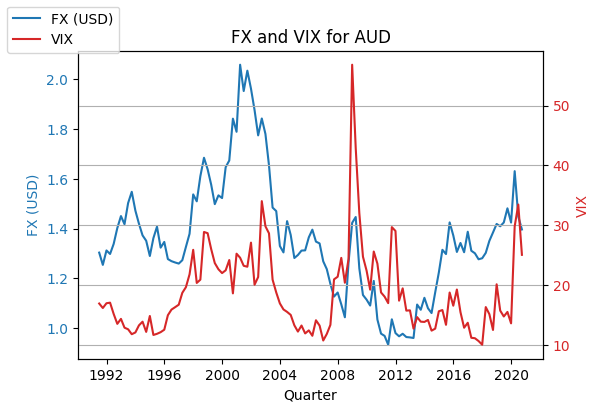

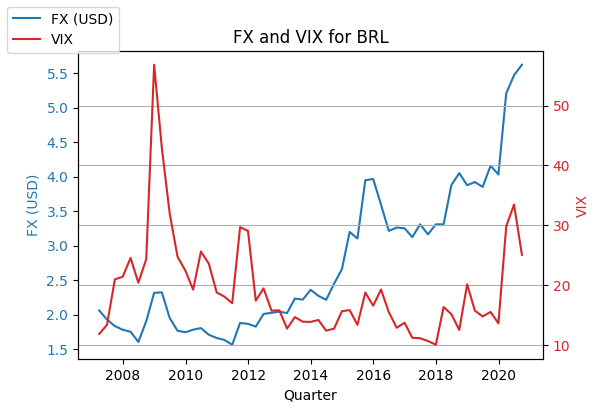

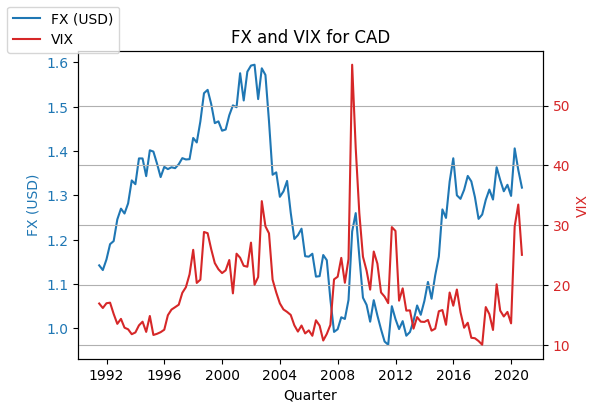

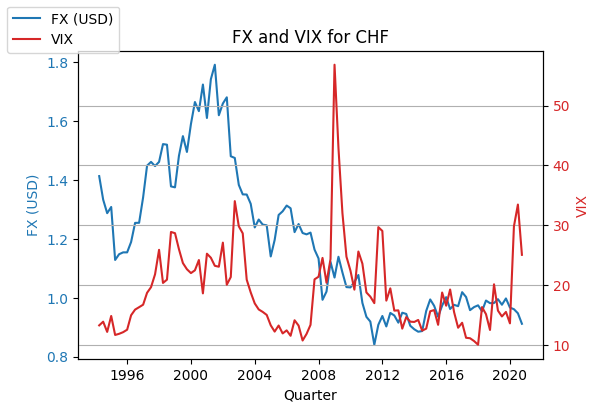

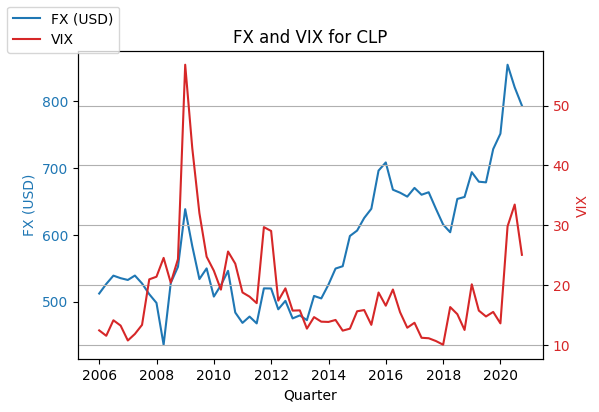

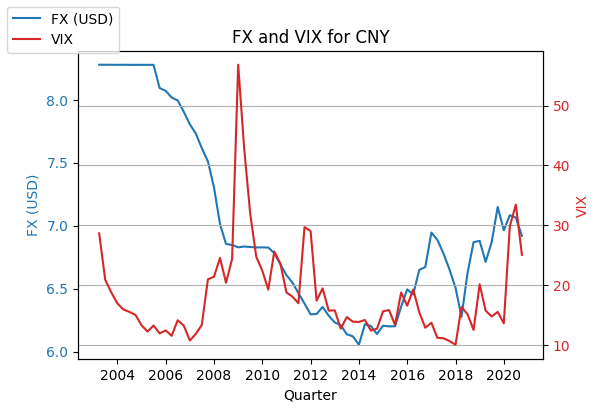

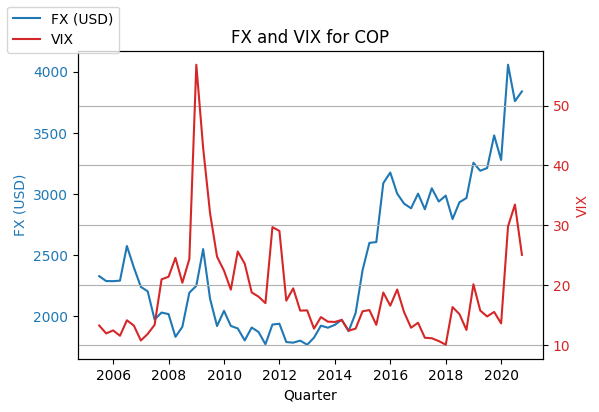

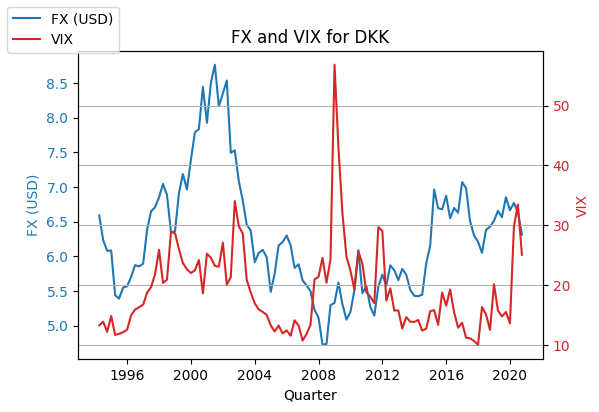

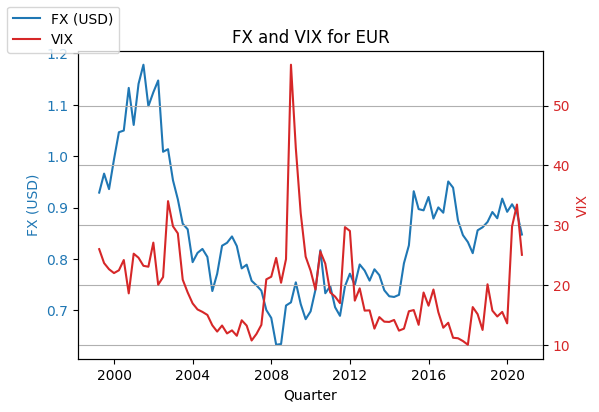

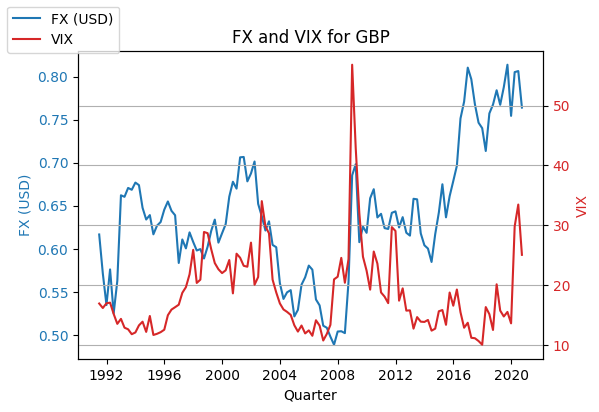

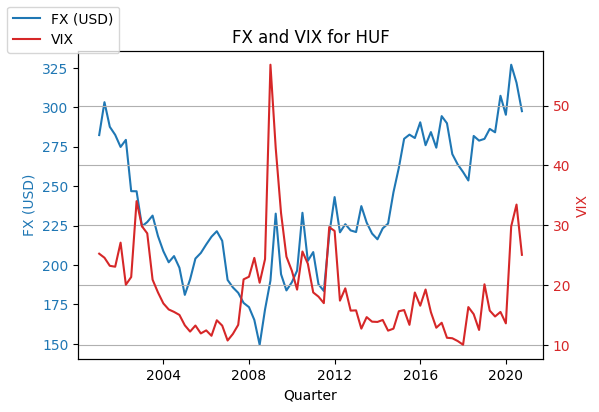

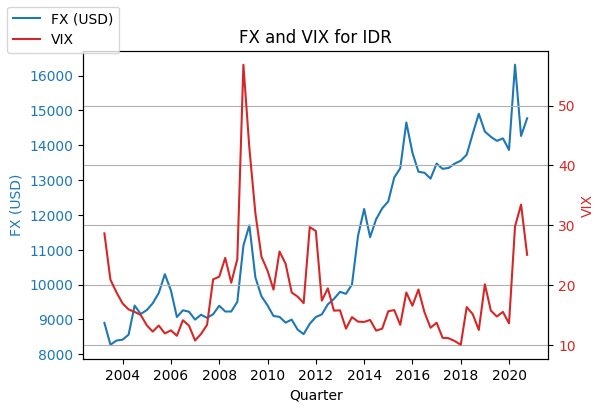

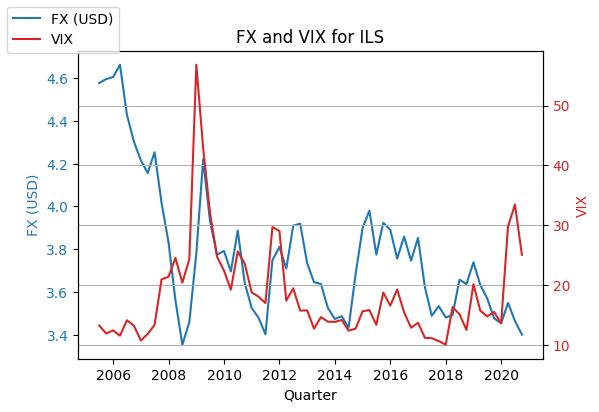

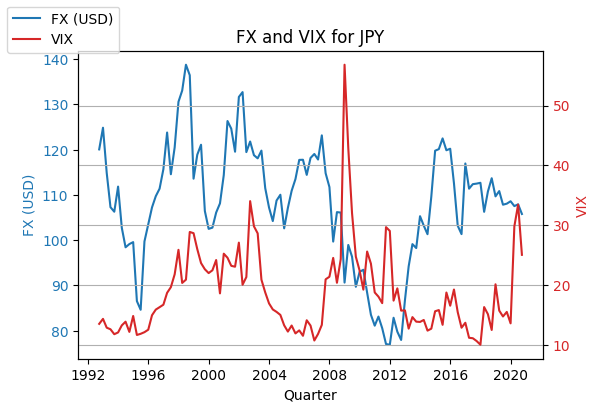

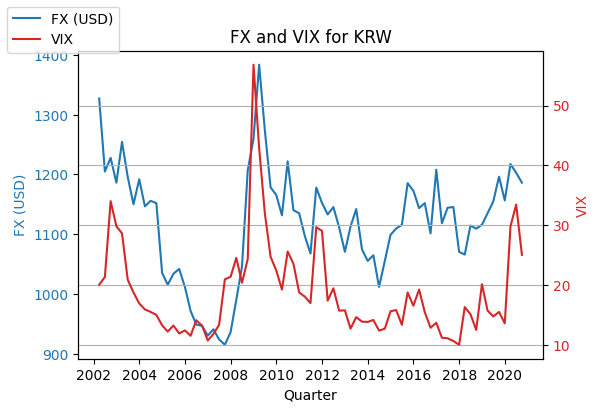

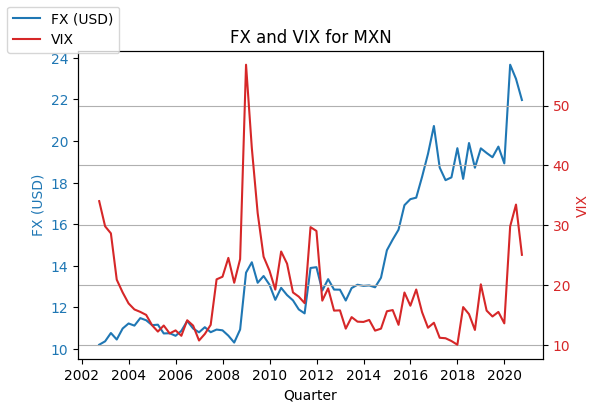

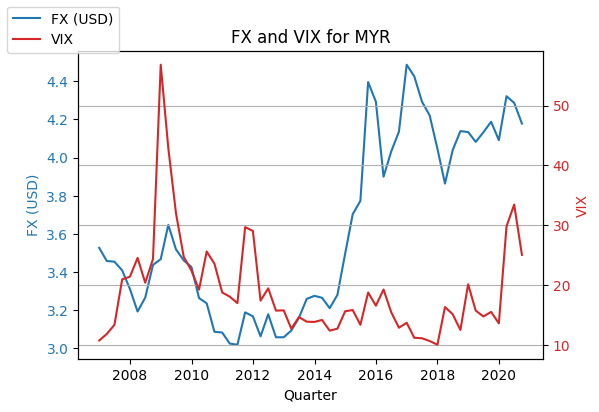

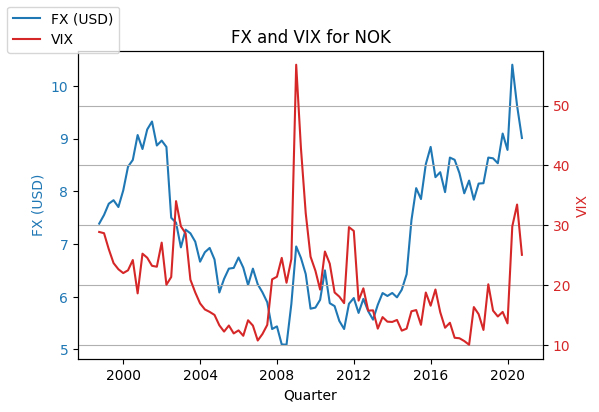

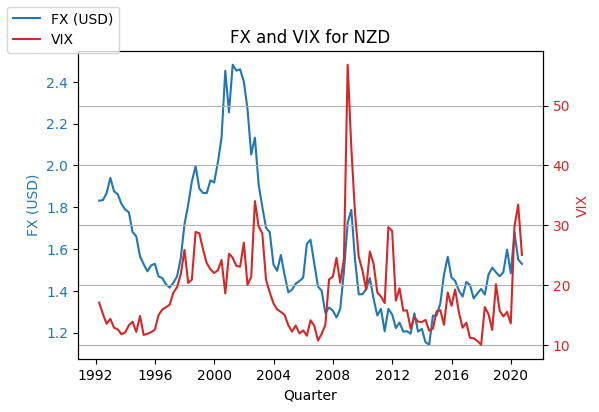

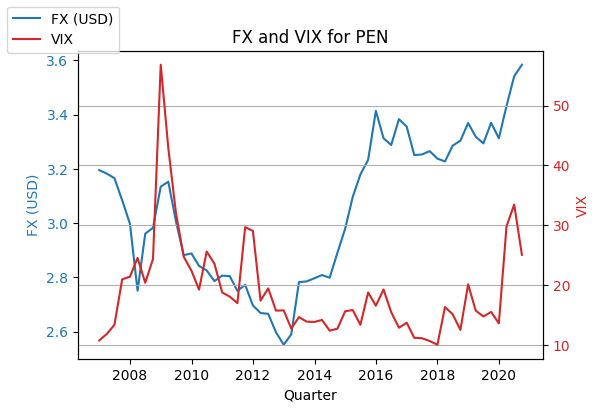

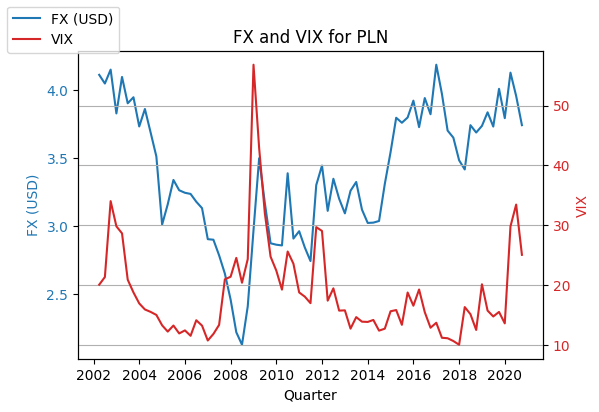

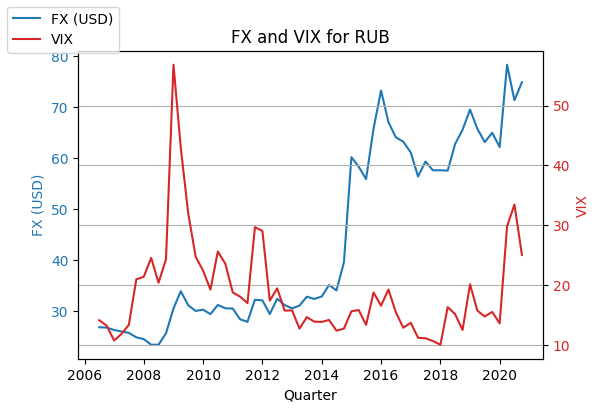

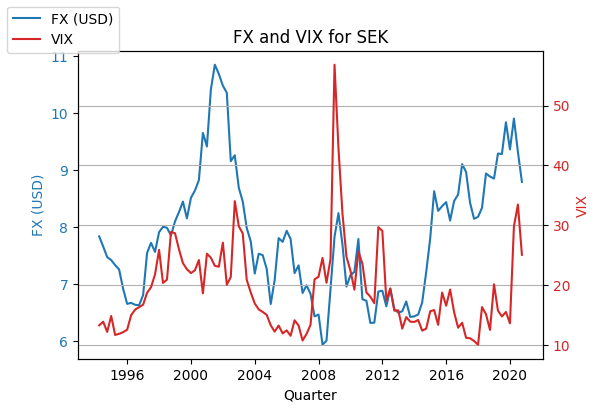

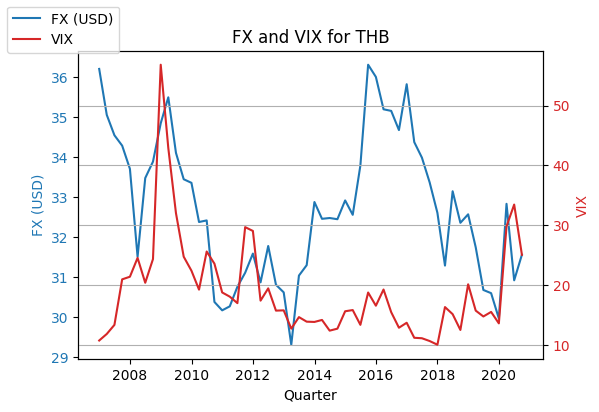

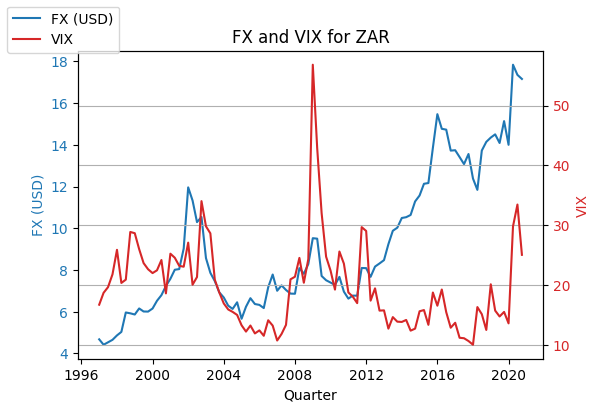

In [23]:
# Plot
grouped_data = data.groupby('currency')

for currency, group in grouped_data:
    fig, ax1 = plt.subplots(figsize=(6,4))

    # fx
    color = 'tab:blue'
    ax1.set_xlabel('Quarter')
    ax1.set_ylabel('FX (USD)', color=color)
    ax1.plot(group.index, group['fx_usd'], color=color, label='FX (USD)')
    ax1.tick_params(axis='y', labelcolor=color)

    # vix
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('VIX', color=color)
    ax2.plot(group.index, group['VIX'], color=color, label='VIX')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.title('FX and VIX for {}'.format(currency))
    fig.legend(loc="upper left")
    plt.grid()

    plt.show()

I may check for stationarity, however, data will be differenced and logged in the analysis phase. Therefore, even if each series is non-stationary it will be transformed in one.

To prepare the data for the equation ${\Delta}log(e_{i,t})=\alpha_{i}+\beta_{i}{\Delta}log(vix_{t})+\epsilon_{i,t}$, I will first log the data and then take the difference of the logged data. 

As a matter of fact, the operator ${\Delta}$ is outside the logarithm, suggesting that I have to take the difference between the logged values at time $t$ and $t-1$. 

On the other hand, if the operator were inside the logarithm $log({\Delta}e_{i,t})$, I would first differenciate the values and than take the logartihm of the difference. 

In [24]:
# Logs
data['fx_usd'] = pd.to_numeric(data['fx_usd'], errors='coerce')
data['VIX'] = pd.to_numeric(data['VIX'], errors='coerce')

data['lfx_usd'] = np.log(data['fx_usd'].where(data['fx_usd'] > 0))
data['lVIX'] = np.log(data['VIX'].where(data['VIX'] > 0))

# Calculate log differences
data['dfx_usd'] = data.groupby('currency')['lfx_usd'].diff()
data['dVIX'] = data.groupby('currency')['lVIX'].diff()

In [25]:
data

,currency,fx_usd,VIX,lfx_usd,lVIX,dfx_usd,dVIX
quarter,,,,,,,
1991-06-30,AUD,1.303271,16.883231,0.264877,2.826321,NaN,NaN
1991-09-30,AUD,1.253918,16.130152,0.226273,2.780690,-0.038604,-0.045631
1991-12-31,AUD,1.311992,16.926364,0.271546,2.828872,0.045273,0.048182
1992-03-31,AUD,1.297859,17.023846,0.260716,2.834615,-0.010831,0.005743
1992-06-30,AUD,1.338330,15.135846,0.291422,2.717066,0.030707,-0.117549
...,...,...,...,...,...,...,...
2019-09-30,ZAR,15.136300,15.476515,2.717096,2.739324,0.071851,0.050399
2019-12-31,ZAR,14.000000,13.561970,2.639057,2.607270,-0.078039,-0.132054
2020-03-31,ZAR,17.837900,29.783385,2.881325,3.393951,0.242268,0.786681


In [26]:
# Check if it differentiated by country
data.isnull().sum()

currency     0
fx_usd       0
VIX          0
lfx_usd      0
lVIX         0
dfx_usd     25
dVIX        25
dtype: int64

In [27]:
# Drop nulls
data = data.dropna()

## Data Analysis

$${\Delta}log(e_{i,t})=\alpha_{i}+\beta_{i}{\Delta}log(vix_{t})+\epsilon_{i,t}$$

In [28]:
# Country-by-country regressions

reg_results = []

for currency in data.currency.unique():
    currency_data = data[data['currency'] == currency]
    X = sm.add_constant(currency_data['dVIX'])
    y = currency_data['dfx_usd']
    model = sm.OLS(y, X).fit()
    conf_int = model.conf_int(alpha=0.05)[1]
    reg_results.append((currency, model.params[0], model.params[1], conf_int[0], conf_int[1], 
                        model.rsquared, model.pvalues[1]))

reg_data = pd.DataFrame(reg_results, columns=['Currency', 'Alpha', 'Beta', 'CI_min', 
                                              'CI_max', 'R_squared', 'P_value'])

def significance(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return ''

reg_data['Significance'] = reg_data['P_value'].apply(significance)

In [29]:
# Plot table
reg_data

,Currency,Alpha,Beta,CI_min,CI_max,R_squared,P_value,Significance
0,AUD,0.000206,0.114184,0.009993,0.161093,0.168161,4.398377e-06,***
1,BRL,0.016096,0.179077,0.036684,0.256361,0.293667,2.315031e-05,***
2,CAD,0.000921,0.088822,0.006885,0.117404,0.247838,1.124188e-08,***
3,CHF,-0.004179,0.006883,0.005039,0.049192,0.001000,7.476456e-01,
4,CLP,0.006192,0.104041,0.020264,0.158514,0.204218,3.270085e-04,***
5,CNY,-0.002561,-0.000394,0.001610,0.016828,0.000031,9.637632e-01,
6,COP,0.006941,0.120014,0.024023,0.187140,0.178264,7.006008e-04,***
7,DKK,-0.000540,0.022415,0.008800,0.065283,0.010232,3.021957e-01,
8,EUR,-0.001058,0.023224,0.009485,0.068576,0.012195,3.114429e-01,
9,GBP,0.001596,0.070293,0.009768,0.109463,0.099002,5.501575e-04,***


The regression table indicates that 7 beta coefficients are non significant, specifically for Swiss Franc, Chinese Yuan, Danish Krone, Euro, Japanese Yen, Malaysian Ringgit, and Peruvian Sol. 

For the other countries - or areas - we can propose an interpretation of the results. This specification is a Log-Log model, meaning that a percentage increase in X results in a beta% increase in Y. 

For example, a percentage increase in the VIX might result in a 11.4% increase in the difference between the Australian Dollar at time $t$ and $t-1$.

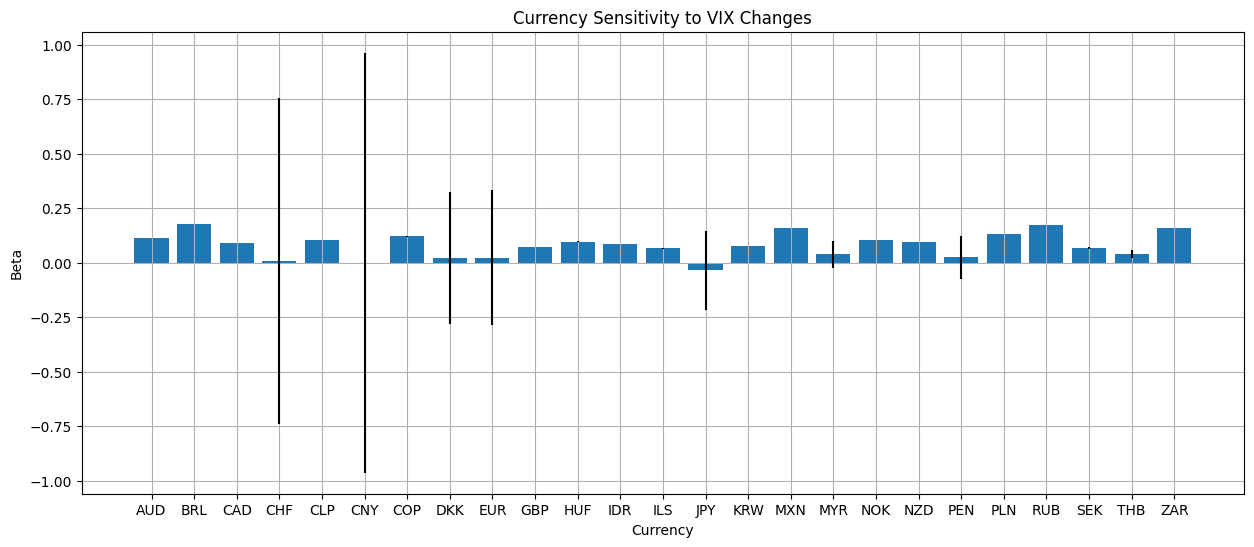

In [30]:
# Plot coefficients
plt.figure(figsize=(15, 6))
plt.bar(reg_data['Currency'], reg_data['Beta'], yerr=reg_data['P_value'])
plt.xlabel('Currency')
plt.ylabel('Beta')
plt.title('Currency Sensitivity to VIX Changes')
plt.grid()
plt.show()

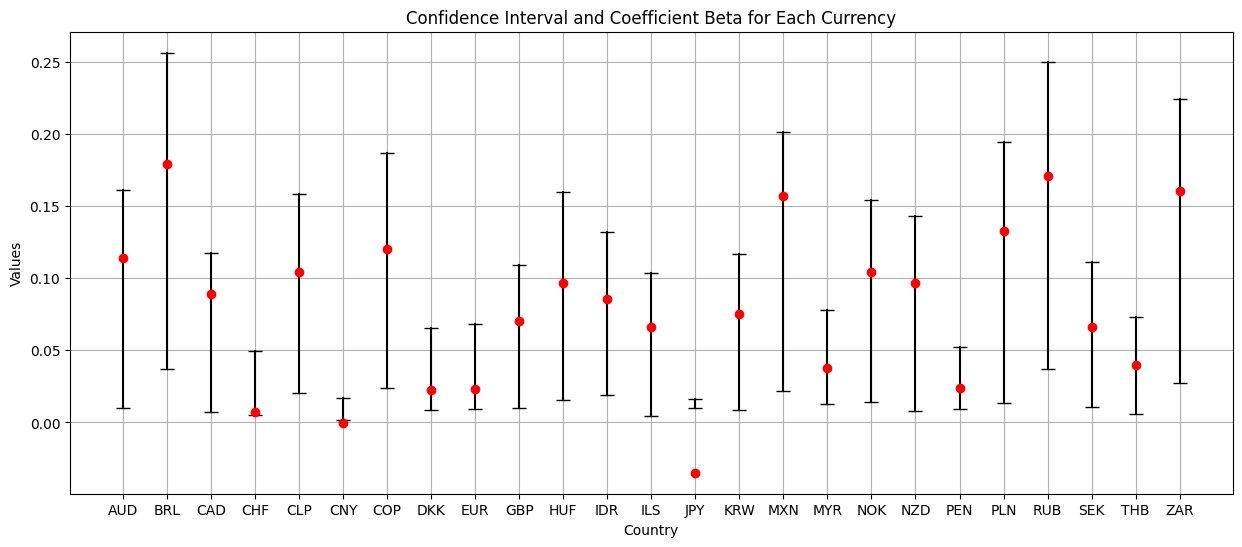

In [31]:
# Plot CIs
plt.figure(figsize=(15, 6))

for index, row in reg_data.iterrows():
    plt.plot([row['Currency'], row['Currency']], [row['CI_min'], row['CI_max']], 'k-', marker='_', markersize=10)
    plt.plot(row['Currency'], row['Beta'], 'ro')

plt.title('Confidence Interval and Coefficient Beta for Each Currency')
plt.xlabel('Country')
plt.ylabel('Values')
plt.grid()
plt.show()

### OLS Assumptions

The Ordinary Least Squares (OLS) method of estimation is utilized in regression analysis to provide estimates of the unknown parameters in a linear regression model by minimizing the sum of squared residuals. They should be to be the Best Linear Unbiased Estimators (BLUE), and to do so they have to meet 6 assumptions.

**Linearity**:
The relationship between the independent variables and the dependent variable is linear. This can be expressed as $Y = β0 + β1X1 + β2X2 + ... + βkXk + ε$, where $Y$ is the dependent variable, $X1, X2, ..., Xk$ are independent variables, $β0, β1, ..., βk$ are parameters to be estimated, and $ε$ is the error term.

**No Perfect Multicollinearity**:
None of the independent variables is a perfect linear function of any other independent variables. Perfect multicollinearity makes it impossible to estimate the coefficients of the model.

**Mean of Errors is Zero**:
The expected value of the error term $ε$ is zero, $E(ε) = 0$.

**Homoscedasticity**:
The variance of the error terms is constant across all levels of the independent variables, meaning the error term does not vary (is homoscedastic) at different values of the independent variables.

**No Auto-correlation of Errors**:
There is no correlation between the error terms, which is particularly relevant in time series data.

**Normality of Errors**:
For inference purposes the error terms should be normally distributed. This assumption is not required for the OLS estimators to be BLUE, but it's needed for small sample sizes to perform t-tests and F-tests. In large samples, this assumption can be relaxed due to the Central Limit Theorem.

### Asymptotically Valid Confidence Intervals for Beta 

**Finite Variance of Error Terms**:
The error terms must have a finite variance $(\sigma^2)$, ensuring that the standard errors of the coefficient estimates, which are used in constructing confidence intervals, can be consistently estimated.

**No Perfect Multicollinearity**:
This standard OLS assumption has profound implications for confidence intervals. Perfect multicollinearity would make the variance of the OLS estimators infinite, precluding the construction of a valid confidence interval. 

**Sampling Distribution**:
For asymptotically valid confidence intervals, the assumption that the sampling distribution of the estimator can be well-approximated by a normal distribution as the sample size increases. This assumption is supported by the Central Limit Theorem.

**Independent and Identically Distributed (i.i.d.) Errors**:
Beyond the assumption of no autocorrelation, for asymptotic properties, the error terms are also assumed to be identically distributed across observations. 

### Causality

#### Standard OLS Assumptions:

Linearity, No Perfect Multicollinearity, Zero Mean of Errors, Homoscedasticity, No Autocorrelation, Normality of Errors.

#### Causal

**Strict Exogeneity**: The error term is uncorrelated with the independent variables for all observations, ensuring that the independent variables are not influenced by the error term.

**No Simultaneous Causality**: The direction of causality is from the independent variables to the dependent variable, without reverse causation.

**No Omitted Variable Bias**: All variables that could affect the dependent variable and are correlated with the independent variables are included in the model.

### Meeting Assumptions

In the case of FX data and VIX, these assumptions might or might not be met. For example, No Omitted Variable Bias is likely not to be met as there are not further variables included in the specification other than the VIX.  

#### Strategies to Adapt the Empirical Approach

**Instrumental Variables (IV)**: Use an IV for VIX that influences forex rates only through VIX and not directly. 

**Panel Data and Fixed Effects**: Utilize fixed effects models with panel data to control for unobserved heterogeneity that might be correlated with both the dependent and independent variables.

**Difference-in-Differences (DiD)**: If applicable, a DiD approach can isolate the causal impact of changes in VIX on forex rates, utilizing natural experiments or policy changes.